<h3>Tutorial notebook for:</h3>

 - Loading selected datasets and models
 - Generating Global Counterfactual Explanations (GCEs) with GLOBE-CE and AReS
 - Comparing results

# Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import copy
from tqdm import tqdm
import pickle
%load_ext autoreload
%autoreload 2

In [2]:
def bold(string):
    return '\033[1m' + string + '\033[0m'

# Select Dataset

In [3]:
from datasets import dataset_loader

In [4]:
name = 'heloc'  # from compas, german_credit, default_credit, adult_income, heloc
dropped_features = []
dataset = dataset_loader(name, dropped_features=dropped_features, n_bins=None)

<strong> Do not normalise input data (GLOBE-CE will handle it) </strong>

<strong> Do not shuffle input data (ensures same train/test split and normalisation values) </strong>

In [5]:
x_train, y_train, x_test, y_test, x_means, x_std = dataset.get_split(normalise=False, shuffle=False,
                                                                     return_mean_std=True)
prop1s = round(np.average(y_train)*100, 2)
print(bold("Proportion of 1s in Training Data:") + " {}%".format(prop1s))

Proportion of 1s in Training Data: 47.19%


In [6]:
X = pd.DataFrame(x_train)
X.columns = dataset.features[:-1]
X_test = pd.DataFrame(x_test)
X_test.columns = dataset.features[:-1]
print(bold("Dataset:") + " {}\n".format(name.replace('_', ' ').title()))
X

Dataset: Heloc



,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,55.0,144.0,4.0,84.0,20.0,3.0,0.0,83.0,2.0,3.0,...,43.0,0.0,0.0,0.0,33.0,74.0,8.0,1.0,1.0,69.0
1,61.0,58.0,15.0,41.0,2.0,4.0,4.0,100.0,15.0,0.0,...,67.0,0.0,0.0,0.0,0.0,74.0,0.0,2.0,1.0,0.0
2,67.0,66.0,5.0,24.0,9.0,0.0,0.0,100.0,15.0,7.0,...,44.0,0.0,4.0,4.0,53.0,66.0,4.0,2.0,1.0,86.0
3,66.0,169.0,1.0,73.0,28.0,1.0,1.0,93.0,76.0,6.0,...,57.0,0.0,5.0,4.0,72.0,83.0,6.0,4.0,3.0,91.0
4,81.0,333.0,27.0,132.0,12.0,0.0,0.0,100.0,15.0,7.0,...,25.0,0.0,1.0,1.0,51.0,89.0,3.0,1.0,0.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7891,68.0,182.0,19.0,94.0,19.0,0.0,0.0,90.0,2.0,4.0,...,40.0,0.0,3.0,3.0,5.0,48.0,3.0,3.0,0.0,55.0
7892,57.0,107.0,3.0,53.0,25.0,1.0,1.0,96.0,15.0,6.0,...,54.0,0.0,7.0,7.0,89.0,36.0,5.0,3.0,2.0,82.0
7893,65.0,94.0,6.0,43.0,31.0,2.0,1.0,91.0,38.0,6.0,...,42.0,0.0,0.0,0.0,18.0,88.0,5.0,3.0,0.0,50.0
7894,75.0,293.0,9.0,143.0,9.0,0.0,0.0,89.0,11.0,4.0,...,22.0,0.0,0.0,0.0,59.0,78.0,3.0,1.0,1.0,57.0


# Select Model

In [7]:
from models import performance

In [ ]:
B_name = 'lr'  # or 'lr' or 'xgb'
if B_name == 'dnn':
    from models import dnn_normalisers as normalisers
elif B_name == 'lr':
    from models import lr_normalisers as normalisers
else:  # no xgb normalisation
    normalisers = {name: False}
with open('models/{}_{}.pkl'.format(name, B_name), 'rb') as f:
    B = pickle.load(f)
normalise = [x_means, x_stds] if normalisers[name] else None

In [9]:
print(bold("Dataset:") + " {}".format(name.replace('_', ' ').title()))
print(bold("Model:") + " {}\n".format(B_name.replace('_', ' ').upper()))
performance(B, x_train, x_test, y_train, y_test, normalise=normalise)

Dataset: Heloc
Model: LR

Train Accuracy: 72.87%
Test Accuracy: 74.89%
Proportion of 1s Predicted (Train): 45.77%
Proportion of 1s Predicted (Test): 47.14%


# Global Evaluation Parameters

In [10]:
n_bins = 10
ordinal_features = []
dropped_features = []

# (Fast) AReS

<h3>Process:</h3>

 - <b>Import and initialise AReS</b>
 - <b>Generate itemsets</b>
     - SD and RL (lower threshold gives larger sets)
     - Or, for example, set affected_subgroup='Foreign-Worker=A201' (SD)
     - RL will then be generated with the provided threshold
 - <b>Generate ground set</b>
     - Lower performance with smaller SD and RL, but faster
     - For Fast AReS, either:
         - set RL_reduction=True
         - OR set RL_reduction=False and then_generation=threshold
     - a good then_generation threshold is the theoretical minimum, 1/|X|
     - the threshold used to generate SD and RL would then have to be higher
     - then_generation seems to perform better on continuous datasets
     - combining RL_reduction with then_generation doesn't seem to perform well
 - <b>Evaluate ground set (for AReS, evaluate the whole ground set)</b>
     - Set plot_accuracy=True
     - Set save_mode=0 and try varying r (a good starting point is r=1000)
     - Choose an optimal r value (normally once the accuracy plot plateaus)
     - Set save_mode=1 or save_mode=2
     - The former will save all r triples, the latter will only save the triples that increase the accuracy of the set as they are added i.e. the vertical blues lines in the accuracy plot)
     - <b>WARNING:</b> This will overwrite the initially large ground set
 - <b>Select the best triples from the ground set</b>
 - <b>Optimise the ground set</b>

In [11]:
from ares import AReS

In [15]:
ares = AReS(model=B, dataset=dataset, X=X, dropped_features=dropped_features,
            n_bins=n_bins, ordinal_features=ordinal_features,
            normalise=normalisers[name], constraints=[20,7,10])

### AReS performance is poor, even with $\mathcal{RL}$-Reduction

Computing Candidate Sets of Conjunctions of Predicates SD and RL
Processing 42156 combinations | Sampling itemset size 6
SD and RL Computed with Lengths 9306 and 9306
Computing Ground Set of Triples V
Reducing RL
RL Reduced from Size 9306 to 1873


100%|██████████| 9306/9306 [02:52<00:00, 53.86it/s]  


Ground Set Computed with Length 1923924


4999it [00:08, 562.68it/s]


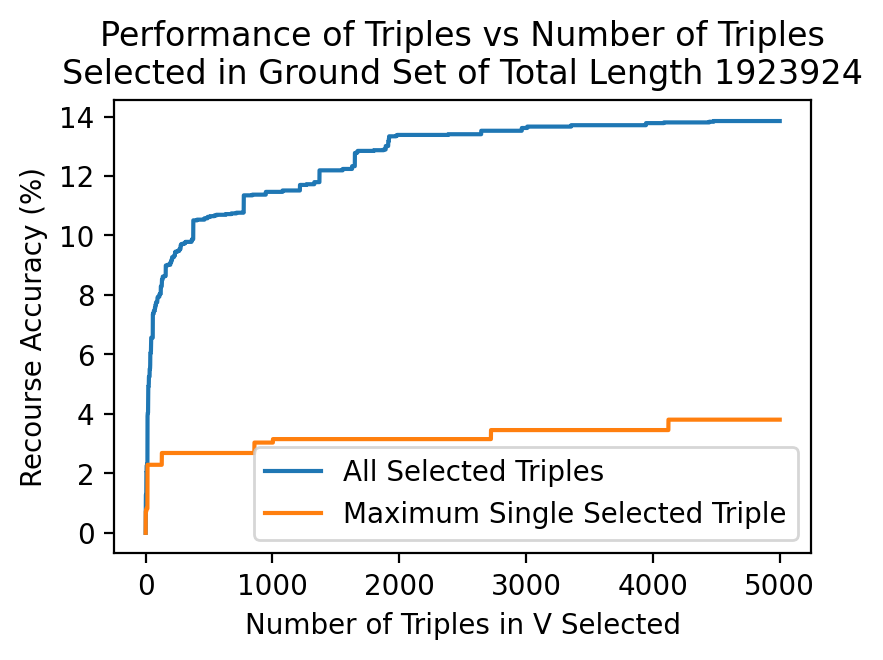

Candidate Set Filtered with Length: 5000
Initialising Copy of Ground Set
While there exists a delete/update operation, loop:
Checking Delete
Checking Add


100%|██████████| 4999/4999 [00:00<00:00, 245229.01it/s]


Checking Exchange


100%|██████████| 4985/4985 [00:04<00:00, 1037.27it/s]


Checking Delete
Checking Add


100%|██████████| 4985/4985 [00:00<00:00, 293112.66it/s]


Checking Exchange


100%|██████████| 4985/4985 [00:04<00:00, 1043.75it/s]


Checking Delete
Checking Add


100%|██████████| 4985/4985 [00:00<00:00, 292911.45it/s]


Checking Exchange


100%|██████████| 4985/4985 [00:04<00:00, 1011.43it/s]
14it [00:00, 578.64it/s]


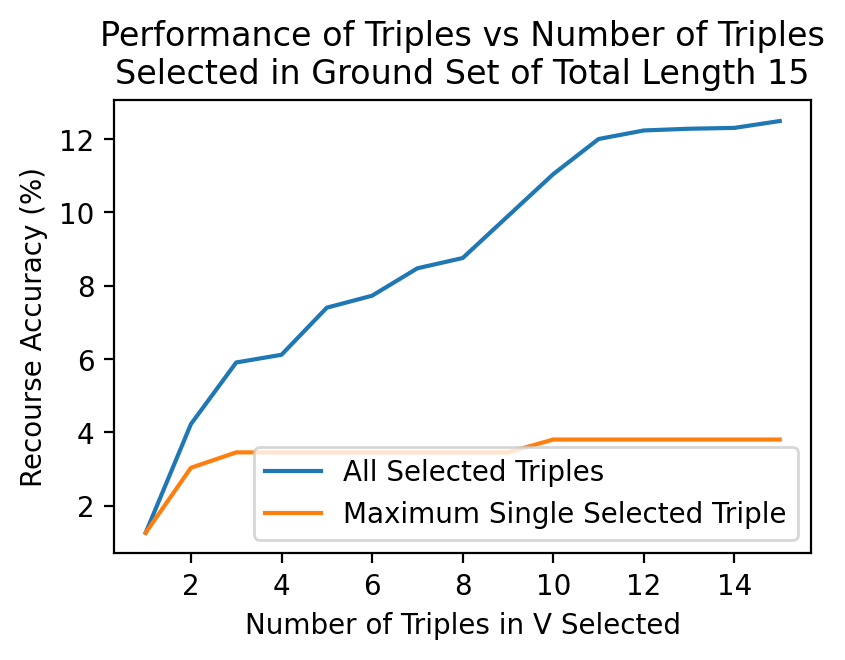

In [16]:
ares.generate_itemsets(apriori_threshold=0.2, max_width=None, # defaults to e2-1
                       affected_subgroup=None, save_copy=False)
# Note: progress bar initial time estimate about 10 times too large
ares.generate_groundset(max_width=None, RL_reduction=True,
                        then_generation=None, save_copy=False)
lams = [1, 0]  # can play around with these lambda values
ares.evaluate_groundset(lams=lams, r=5000, save_mode=1,
                        disable_tqdm=False, plot_accuracy=True)
ares.select_groundset(s=5000)
ares.optimise_groundset(lams=lams, factor=1, print_updates=False,
                        print_terms=False)

In [21]:
print(bold("Accuracy:") + " {}%".format(round(ares.R.accuracy, 2)))
# only inputs with positive counterfactual predictions
print(bold("Average Cost:") + " {}".format(round(ares.R.average_cost, 2)))

print(bold("\nAccuracy Upper Bound (Evaluated/Sorted Ground Set):")
      + " {}%".format(round(ares.V.accuracy, 2)))

costs_ares, corrects_ares = ares.accuracy_cost_bounds(ares.R.cost_vector)

Accuracy: 12.49%
Average Cost: 1.18

Accuracy Upper Bound (Evaluated/Sorted Ground Set): 13.85%


### Hence, use Then Generation (performs well on continuous data)

In [22]:
# use higher apriori threshold than usual
ares.generate_itemsets(apriori_threshold=0.6, max_width=None, # defaults to e2-1
                       affected_subgroup=None, save_copy=False)

Computing Candidate Sets of Conjunctions of Predicates SD and RL
Processing 300 combinations | Sampling itemset size 6
SD and RL Computed with Lengths 199 and 199


In [23]:
q = 1/X.shape[0]  # threshold for apriori during Then Generation

In [33]:
# generates a smaller groundset for a given time, though normally with better rules
ares.generate_groundset(max_width=None, RL_reduction=False,
                        then_generation=q, save_copy=False)

Computing Ground Set of Triples V


100%|██████████| 199/199 [01:13<00:00,  2.70it/s]

Ground Set Computed with Length 398452


4999it [00:12, 410.90it/s]


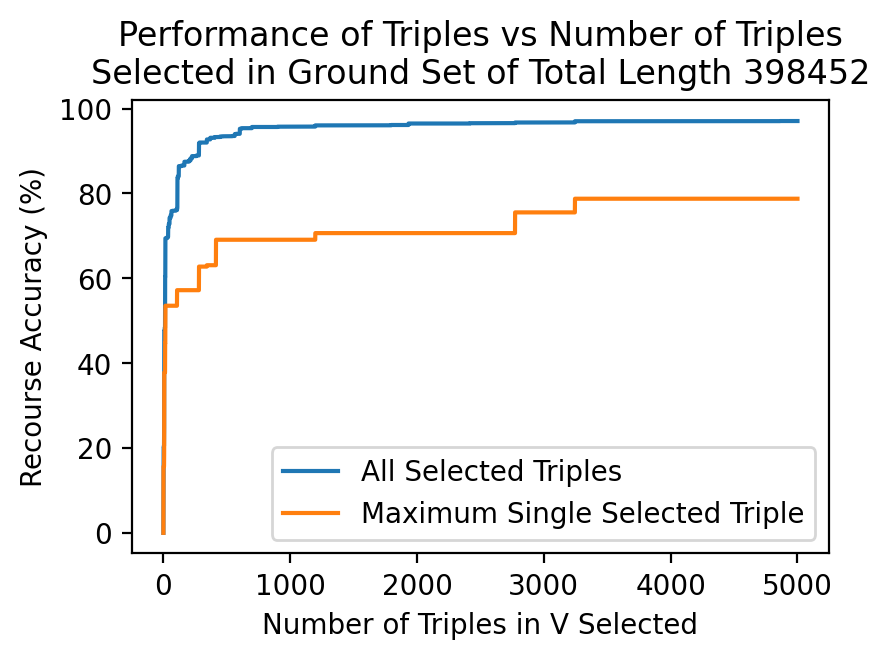

In [34]:
lams = [1, 10]  # can play around with these lambda values
ares.evaluate_groundset(lams=lams, r=5000, save_mode=1,
                        disable_tqdm=False, plot_accuracy=True)

In [35]:
ares.select_groundset(s=5000)

Candidate Set Filtered with Length: 5000


Initialising Copy of Ground Set
While there exists a delete/update operation, loop:
Checking Delete
Checking Add


100%|██████████| 4999/4999 [00:00<00:00, 72828.25it/s]


Checking Exchange


100%|██████████| 4980/4980 [00:06<00:00, 805.62it/s] 


Checking Delete
Checking Add
Checking Exchange


100%|██████████| 4980/4980 [00:04<00:00, 1085.11it/s]


Checking Delete
Checking Add
Checking Exchange


100%|██████████| 4980/4980 [00:04<00:00, 1073.71it/s]
19it [00:00, 378.40it/s]


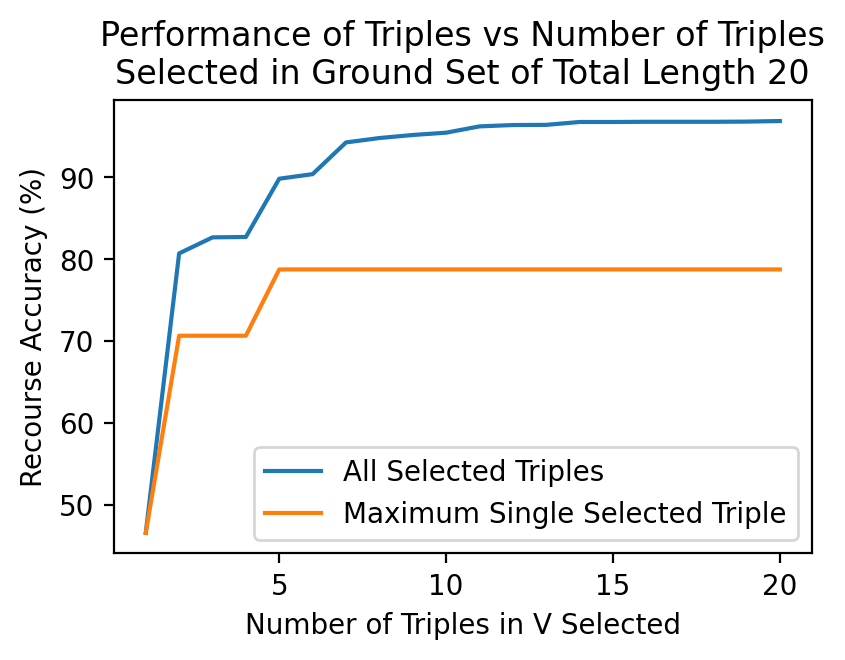

In [36]:
ares.optimise_groundset(lams=lams, factor=1, print_updates=False,
                        print_terms=False, save_copy=False)

In [37]:
print(bold("Accuracy:") + " {}%".format(round(ares.R.accuracy, 2)))
# only inputs with positive counterfactual predictions
print(bold("Average Cost:") + " {}".format(round(ares.R.average_cost, 2)))

print(bold("\nAccuracy Upper Bound (Evaluated/Sorted Ground Set):")
      + " {}%".format(round(ares.V.accuracy, 2)))

costs_ares, corrects_ares = ares.accuracy_cost_bounds(ares.R.cost_vector)

Accuracy: 96.89%
Average Cost: 1.62

Accuracy Upper Bound (Evaluated/Sorted Ground Set): 97.06%


In [38]:
# clear the output to save space after running this cell
print(bold("Final {} Triples Post-Optimisation\n".format(ares.R.length)))
for triple in ares.R.triples:
    outer_ifs, inner_ifs, thens = [sorted([j for j in triple[i]]) for i in range(3)]
    print(bold("If") + " {}:".format(', '.join(outer_ifs)))
    print(bold("\t  If") + " {}".format(', '.join(inner_ifs)))
    print(bold("\tThen") + " {}\n".format(', '.join(thens)))

Final 20 Triples Post-Optimisation

If MSinceMostRecentTradeOpen = (-0.227, 22.7], NumInqLast6M = (-0.066, 6.6]:
	  If NumInqLast6Mexcl7days = (-0.066, 6.6], PercentTradesNeverDelq = (90.0, 100.0]
	Then NumInqLast6Mexcl7days = (6.6, 13.2], PercentTradesNeverDelq = (70.0, 80.0]

If NetFractionInstallBurden = (47.1, 94.2], NumInqLast6M = (-0.066, 6.6]:
	  If MSinceMostRecentTradeOpen = (-0.227, 22.7], NumInqLast6Mexcl7days = (-0.066, 6.6]
	Then MSinceMostRecentTradeOpen = (-0.227, 22.7], NumInqLast6Mexcl7days = (19.8, 26.4]

If NumTrades90Ever2DerogPubRec = (-0.019, 1.9]:
	  If MSinceMostRecentInqexcl7days = (-0.024, 2.4], NumTrades60Ever2DerogPubRec = (-0.019, 1.9]
	Then MSinceMostRecentInqexcl7days = (9.6, 12.0], NumTrades60Ever2DerogPubRec = (-0.019, 1.9]

If MSinceMostRecentTradeOpen = (-0.227, 22.7], PercentTradesNeverDelq = (90.0, 100.0]:
	  If MSinceMostRecentInqexcl7days = (-0.024, 2.4]
	Then MSinceMostRecentInqexcl7days = (9.6, 12.0]

If MSinceMostRecentInqexcl7days = (-0.024, 2

# GLOBE-CE

In [39]:
from globe_ce import GLOBE_CE

In [40]:
# AReS initiated to determine bin widths for costs- n_bins must be same as above
ares_widths = AReS(model=B, dataset=dataset, X=X, n_bins=n_bins, normalise=normalise)
bin_widths = ares_widths.bin_widths

In [41]:
# initialise GLOBE_CE
globe_ce = GLOBE_CE(model=B, dataset=dataset, X=X, affected_subgroup=None,
                    dropped_features=dropped_features, delta_init='zeros',
                    ordinal_features=ordinal_features, normalise=normalise,
                    bin_widths=bin_widths, monotonicity=None, p=1)

### Sample random $\delta$ vectors (translations)

100%|██████████| 2000/2000 [00:00<00:00, 2413.70it/s]


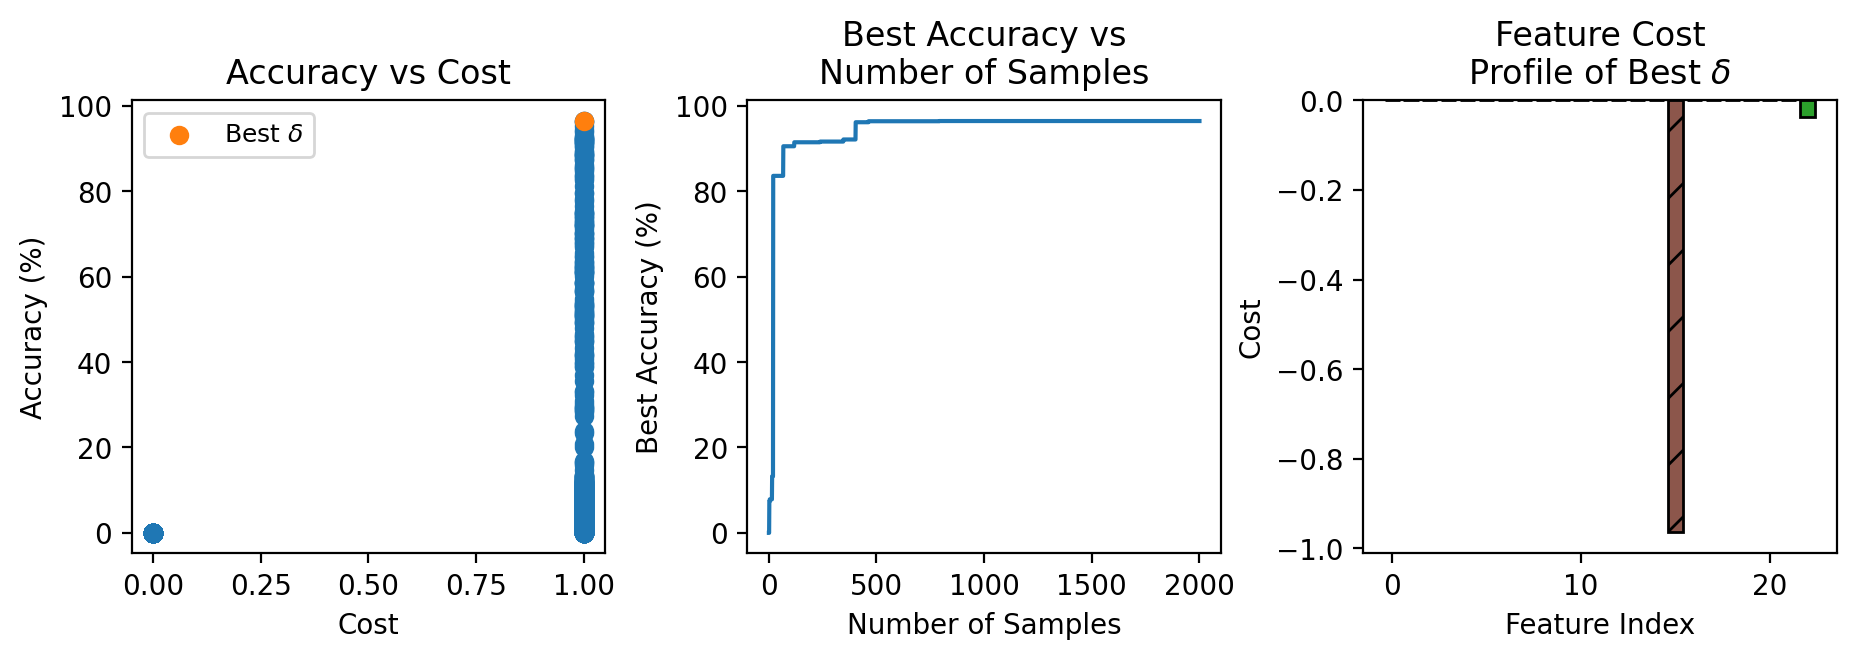

In [48]:
# note that the Cumulative Rules Chart (CRC) is possibly more
# intepretable without continuous features, and they also have
# little impact on the GCEs in this case, so we drop them
globe_ce.sample(n_sample=2000, magnitude=1, sparsity_power=1,  # magnitude is the fixed cost sampled at
                idxs=None, n_features=2, disable_tqdm=False,
                plot=True, seed=0, scheme='random',
                dropped_features=dropped_features)
delta = globe_ce.best_delta

### Scale best $\delta$ and Compute Minimum Costs/Scalars per Input

In [49]:
corrects, costs, scalars = globe_ce.scale(delta=delta, vector=True, plot=True)
min_costs = globe_ce.min_scalar_costs(costs=costs, return_idxs=False)

100%|██████████| 1000/1000 [00:00<00:00, 3076.89it/s]


Unable to find recourse for 4/4282 inputs


### Compute Best Average Costs given each Input uses its Minimum Scalar

In [50]:
costs_bound, corrects_bound = globe_ce.accuracy_cost_bounds(min_costs)

### Accuracy-Cost Profiles and Minimum Costs Histogram

 - Here, the <b>"optimal"</b> accuracy-cost profile is the one for which the minimum cost is used for each individual input. The plot is then built by sorting each input by minimum cost and adding each input one by one
     - E.g. if the lowest cost (with correct recourse) was 1 in a group of 100 inputs, the first accuracy-cost plot point would be 1% accuracy at average cost 1. If the second and third lowest costs were also 1, the next points are 2% and 3% accuracy at average cost 1. If the fourth lowest cost was 2, the next point is 4% accuracy at average cost 1.25, etc, until the maximum accuracy is reached
 
 - Unlike German Credit, we don't bother with the <b>"clustered"</b> profile, since we can interpret scaling continuous variables more easily

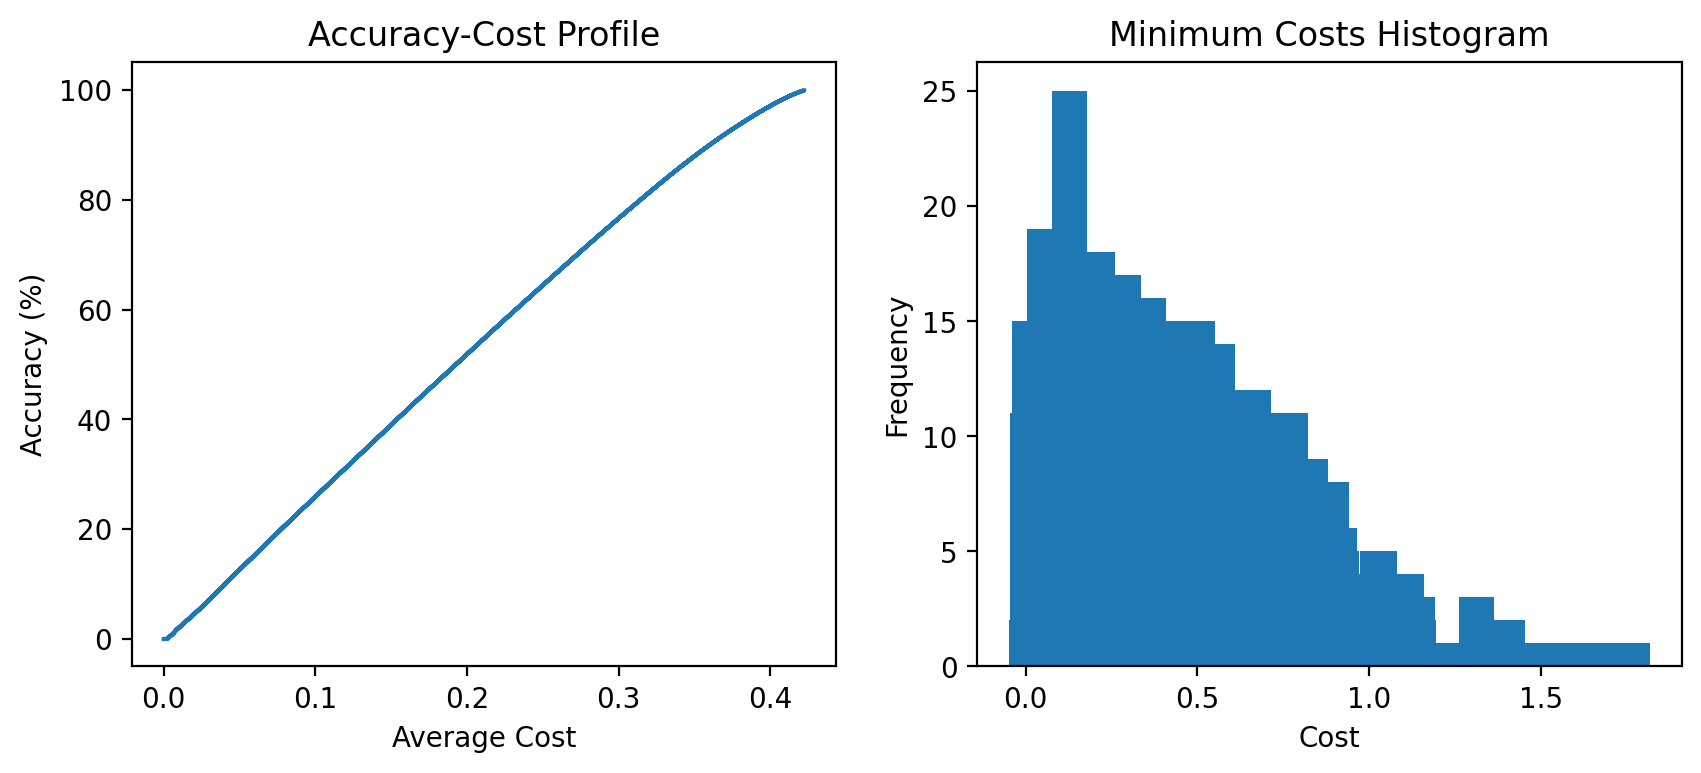

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=2, dpi=200)
fig.set_figwidth(10)
ax[0].step(costs_bound, corrects_bound, where='post')
ax[0].set_ylim([-5, 105])
ax[0].set_title('Accuracy-Cost Profile')
ax[0].set_xlabel('Average Cost')
ax[0].set_ylabel('Accuracy (%)')
ax[1].set_title('Minimum Costs Histogram')
width = 0.1
mins = min_costs[min_costs!=0]
# Using barplot since its easier
unique, count = np.unique(mins, return_counts=True)
ax[1].bar(unique, count, width=width)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Cost')
plt.show()

# Comparing GLOBE-CE to AReS

 - times can also be added by wrapping the code with:
 - start_time = time.time()
 - run AReS (or GLOBE-CE)
 - time_ares = time.time() - start_time

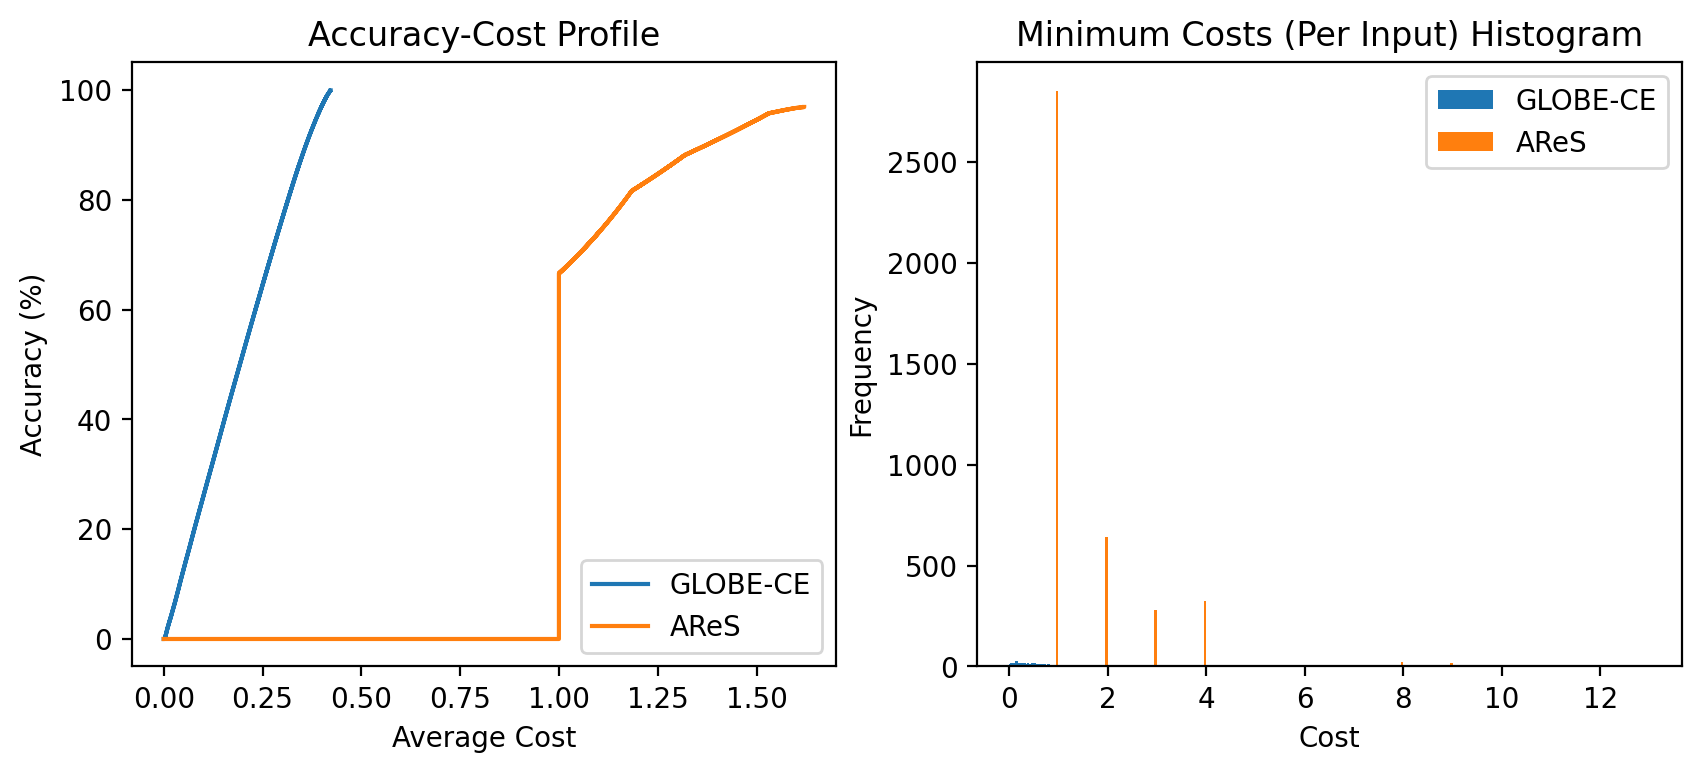

[GLOBE-CE]	Maximum Accuracy:			 99.91%
[GLOBE-CE]	Average Cost at Maximum Accuracy:	 0.42

[AReS]		Maximum Accuracy:			 96.89%
[AReS]		Average Cost at Maximum Accuracy:	 1.62


In [54]:
fig, ax = plt.subplots(nrows=1, ncols=2, dpi=200)
fig.set_figwidth(10)

ax[0].step(costs_bound, corrects_bound, where='post', label='GLOBE-CE')
ax[0].step(costs_ares, corrects_ares, where='post', label='AReS')
ax[0].set_ylim([-5, 105])
ax[0].set_title('Accuracy-Cost Profile')
ax[0].set_xlabel('Average Cost')
ax[0].set_ylabel('Accuracy (%)')
ax[0].legend()

ax[1].set_title('Minimum Costs (Per Input) Histogram')
width = 0.05
mins = min_costs[min_costs!=0]
unique, count = np.unique(mins, return_counts=True)
ax[1].bar(unique+width/2, count, width=width, label='GLOBE-CE')
mins_ares = ares.R.cost_vector[~np.isnan(ares.R.cost_vector)]
unique_ares, count_ares = np.unique(mins_ares, return_counts=True)
ax[1].bar(unique_ares-width/2, count_ares, width=width, label='AReS')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Cost')
ax[1].legend()

plt.show()

print(bold("[GLOBE-CE]\tMaximum Accuracy:\t\t\t") + " {}%".format(round(corrects_bound[-1], 2)))
# only inputs with positive counterfactual predictions
print(bold("[GLOBE-CE]\tAverage Minimum Cost at Maximum Accuracy:\t") + " {}".format(round(costs_bound[-1], 2)))

print(bold("\n[AReS]\t\tMaximum Accuracy:\t\t\t") + " {}%".format(round(ares.R.accuracy, 2)))
# only inputs with positive counterfactual predictions
print(bold("[AReS]\t\tAverage Minimum Cost at Maximum Accuracy:\t") + " {}".format(round(ares.R.average_cost, 2)))

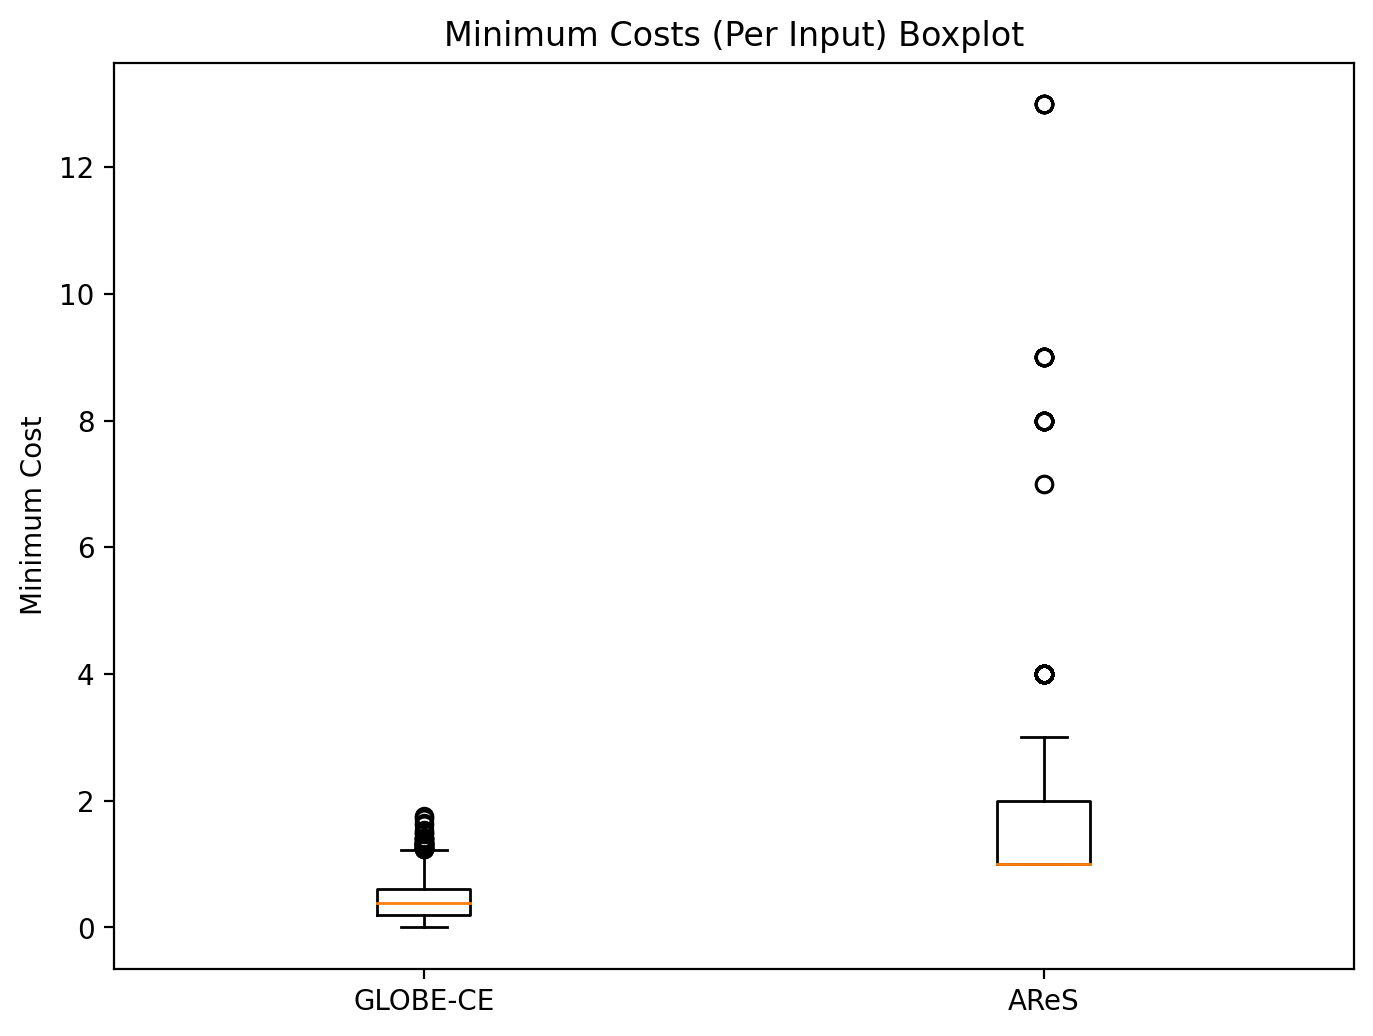

In [69]:
plt.figure(figsize=(8, 6), dpi=200)
plt.boxplot([mins, mins_ares], labels=['GLOBE-CE', 'AReS'])
plt.ylabel('Minimum Cost')
plt.title('Minimum Costs (Per Input) Boxplot')
plt.show()